In this notebook, we demonstrate how are embeddings extracted from the image. 

In [1]:
import pathml
from pathml import HESlide
import matplotlib.pyplot as plt
import numpy as np
from pathml.core import HESlide
import pandas as pd

%matplotlib inline

# Load image

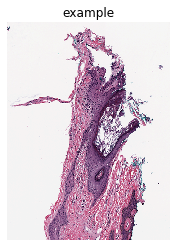

In [4]:
wsi = HESlide("tests/testdata/small_HE.svs", name = "example")
wsi.plot()

In [5]:
wsi #SlideData object

SlideData(name='example',
	slide_type=SlideType(stain=HE, platform=None, tma=None, rgb=True, volumetric=None, time_series=None),
	filepath='tests/testdata/small_HE.svs',
	backend='openslide',
	image shape: (2967, 2220),
	0 tiles: [],
	0 masks: [],
	labels=None,
	counts=None)

In [6]:
wsi.slide.get_image_shape(level = 0) # check i for bigger images

(2967, 2220)

# Obtain tiles

In [8]:
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

In [8]:
pipeline = Pipeline([
    BoxBlur(kernel_size=15),
    TissueDetectionHE(mask_name = "tissue", min_region_size=500,
                      threshold=30, outer_contours_only=True)
])

In [9]:
%%time
wsi.run(pipeline, distributed=False,tile_size = 64)# extract tiles

CPU times: user 2min 26s, sys: 10.6 s, total: 2min 36s
Wall time: 2min 37s


In [10]:
wsi.tiles

1564 tiles: ['(0, 0)', '(0, 1024)', '(0, 1088)', '(0, 1152)', '(0, 1216)', '(0, 128)', ...]

In [13]:
wsi.tiles[1] #Tile object

Tile(coords=(0, 1024),
	name=None,
	image shape: (64, 64, 3),
	slide_type=SlideType(stain=HE, platform=None, tma=None, rgb=True, volumetric=None, time_series=None),
	labels=None,
	1 masks: ['tissue'],
	counts=None)

In [13]:
num_tiles = len(wsi.tiles)
coords = []
for i in range(num_tiles):
    coords.append(wsi.tiles[i].coords)

In [16]:
# save coordinates of tiles 
pd.DataFrame(coords).to_csv('coordinates.csv',index = False)

# Extracting features (embeddings) of each tile


## Helper functions

In [39]:
# use model.eval()

def get_features_eval(t,model):
    """
    t: single tile in SlideData object, eg wsi.tiles[0] 
    model: model loaded
    """
    # transpose to 3,32,32, then tensor, 
    test = torch.tensor(t.image.transpose([2,1,0]))

    # reshape image to 4D 
    # PyTorch expects a 4-dimensional input, the first dimension being the number of samples
    test = test.unsqueeze(0)

    # transform to float, otherwise there's mistake on double/float
    # shape = 1,3,32,32
    test = test.float() 
    
    # eval mode
    model.eval()
    
    # pooled features
    o_pooled = model(test)

    # flatten the pooled vector: 1 X D
    o_pooled_flat = o_pooled.reshape(1,-1).detach().numpy()
    
    return o_pooled_flat

# make into a function
def get_features_wsi_eval(wsi,model):
    '''
    wsi: SlideObject
    get_features: function above: Tile -> Tensor
    model: model loaded above
    '''
    features = []
    for ti in wsi.tiles:
        features.append(get_features_eval(ti,model))
    features = np.vstack(np.array(features))
    
    return features

## Model 1: Normal imagenet-trained models

In [8]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
import timm

In [58]:
# model 
m = timm.create_model('xception41', pretrained=True,num_classes = 0)

# with model.eval
features_eval = get_features_wsi_eval(wsi,m)

# store that in a dataframe, for the pca operations later 
df = pd.DataFrame(features_eval)
df.to_csv('tilefeatures_eval.csv', index=False) 

## Model 2: Pathology-trained model

In [2]:
pip install --upgrade torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchtext

  Using cached torchtext-0.10.1-cp38-cp38-macosx_10_9_x86_64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pytorch-lightning

  Using cached pytorch_lightning-1.4.9-py3-none-any.whl (925 kB)
  Using cached torchmetrics-0.5.1-py3-none-any.whl (282 kB)
  Using cached pyDeprecate-0.3.1-py3-none-any.whl (10 kB)
  Using cached tensorboard-2.6.0-py3-none-any.whl (5.6 MB)
  Using cached aiohttp-3.7.4.post0-cp38-cp38-macosx_10_14_x86_64.whl (648 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-macosx_10_9_x86_64.whl (3.5 MB)
  Using cached Markdown-3.3.4-py3-none-any.whl (97 kB)
     |████████████████████████████████| 288 kB 3.4 MB/s eta 0:00:01
  Using cached google_auth-1.35.0-py2.py3-none-any.whl (152 kB)
     |████████████████████████████████| 131 kB 52.9 MB/s eta 0:00:01
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 1.0 MB 53.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 34.7 MB/s eta 0:00:01
  Using cached tensorboard_plugin_wit-1.8.0-py3-none-any.whl (781 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (1

In [18]:
import torchvision
import torch

In [19]:
MODEL_PATH = '/Users/jiesun/Dropbox/2021_FALL/DanaFaber/self-supervised-histopathology/tenpercent_resnet18.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


In [26]:
# function to load model weights
def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)
    return model

# load model
m2 = torchvision.models.__dict__['resnet18'](pretrained=False)
state = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

m2 = load_model_weights(m2, state_dict)
if RETURN_PREACTIVATION:
    m2.fc = torch.nn.Sequential()
else:
    m2.fc = torch.nn.Linear(m2.fc.in_features, NUM_CLASSES)

In [38]:
# run with the whole wsi
features2 = get_features_wsi(wsi,m2)
features2.shape

(1564, 512)

In [33]:
# store that in a dataframe, for the pca operations later 
df = pd.DataFrame(features2)
df.to_csv('tilefeatures2.csv', index=False) 

In [40]:
# run with the whole wsi
features2_eval = get_features_wsi_eval(wsi,m2)
# store that in a dataframe, for the pca operations later 
df = pd.DataFrame(features2_eval)
df.to_csv('tilefeatures2_eval.csv', index=False) 

Now we have 2 versions of embeddings, generated using 2 different models. We will visualize them using TSNE.

# TSNE plots

In [44]:
# draw tsne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

tsne = TSNE()

In [ ]:
# note: features or features_eval below are ARRAYS
# There are slight differences if we plot with dataframes, loaded from csv.

/Users/jiesun/opt/anaconda3/envs/pathml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


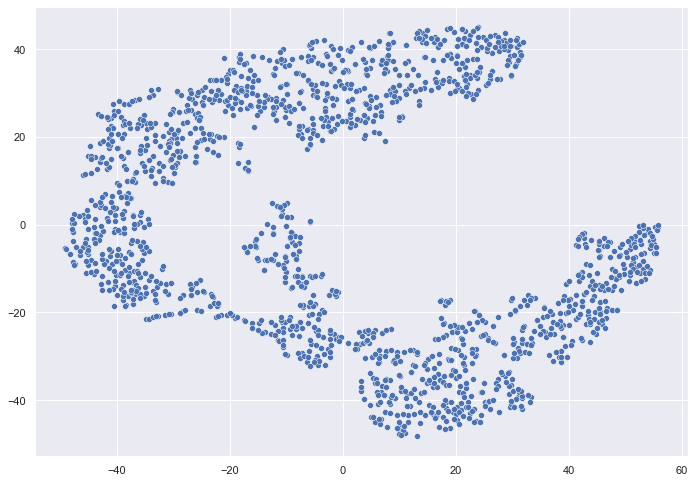

In [59]:
# model1, model.eval
X_embedded_eval = tsne.fit_transform(features_eval)
sns.scatterplot(X_embedded_eval[:,0], X_embedded_eval[:,1],legend='full', palette=palette)

/Users/jiesun/opt/anaconda3/envs/pathml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


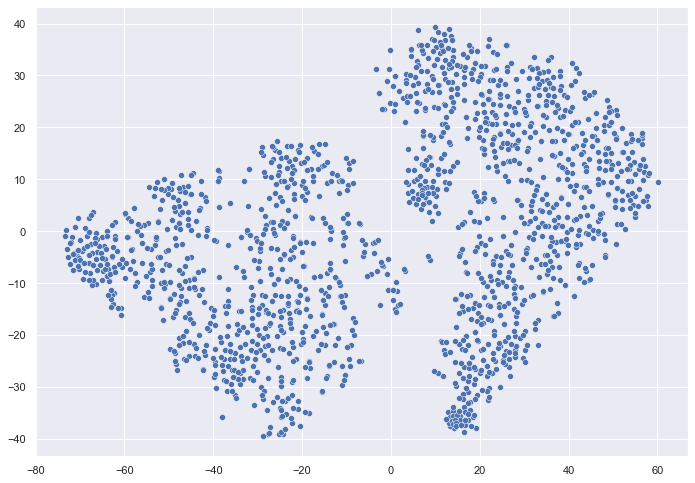

In [44]:
# model2, model.eval
X_embedded_eval = tsne.fit_transform(features2_eval)
sns.scatterplot(X_embedded_eval[:,0], X_embedded_eval[:,1],legend='full', palette=palette)

A superficial view of the TSNE plot indicates that the embeddings from model 2 (pre-trained on other pathology images) might be clustering the tiles better, i.e. the 2 groups are more segregated, corresponding to the blank vs non-blank tiles devide. 

